# MLOps Sentiment Analysis - Sistema di Monitoraggio Completo

Questo notebook implementa il sistema completo di monitoraggio e retraining per il modello di sentiment analysis. Include:
- ✅ Download del dataset
- ✅ Valutazione del modello su test set (Accuracy, F1-Score)
- ✅ Logging delle predizioni con timestamp
- ✅ Tracking delle metriche (distribuzione sentiment, confidence media)
- ✅ Rilevazione del drift confrontando con baseline
- ✅ Trigger di retraining basato su performance
- ✅ Visualizzazioni dei risultati
- ✅ Test unitari della funzione principale

In [27]:
# 1. Importare Librerie Necessarie
import sys
import os
import numpy as np
import pandas as pd
import json
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any
from datetime import datetime, timedelta
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Librerie di visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn per le metriche
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

# Datasets
from datasets import load_dataset

# Modelli locali
sys.path.insert(0, '/workspaces/mlops-ex')
from src.sentiment_model import analyze_sentiment
from src.monitoring import PredictionLogger, PredictionLog
from src.metrics import MetricsTracker, SentimentMetrics
from src.drift_detection import DriftDetector, DriftReport
from src.retraining import RetrainingManager, RetrainingTrigger

# Configurazione di stile
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Tutte le librerie importate correttamente")
print(f"Python version: {sys.version}")

✅ Tutte le librerie importate correttamente
Python version: 3.12.1 (main, Nov 27 2025, 10:47:52) [GCC 13.3.0]


In [28]:
# 2. Configurare il Sistema di Logging
from pathlib import Path

# Crea le directory necessarie
logs_dir: Path = Path("logs")
logs_dir.mkdir(exist_ok=True)

# Inizializza i componenti del sistema di monitoraggio
logger: PredictionLogger = PredictionLogger(log_dir="logs")
metrics_tracker: MetricsTracker = MetricsTracker(metrics_dir="logs")
drift_detector: DriftDetector = DriftDetector(
    baseline_file="logs/baseline_distribution.json",
    drift_threshold=0.15,
    metrics_dir="logs"
)
retraining_manager: RetrainingManager = RetrainingManager(
    min_samples_for_retraining=50,
    confidence_threshold=0.70,
    drift_detector=drift_detector,
    metrics_dir="logs"
)

# Pulisci i log precedenti (opzionale)
logger.clear_logs()
metrics_tracker.clear_metrics()
drift_detector.clear_drift_reports()
retraining_manager.clear_triggers()

print("✅ Sistema di logging configurato")
print(f"Directory dei log: {logs_dir.absolute()}")

✅ Sistema di logging configurato
Directory dei log: /workspaces/mlops-ex/logs


In [29]:
from datasets import load_dataset, Dataset
import os

# Try loading tweet_eval default builder first
dataset = None
try:
    dataset = load_dataset("tweet_eval")
    test_dataset = dataset['test']
except Exception as e:
    print("Default tweet_eval load failed:", e)
    dataset = None
    test_dataset = None

# If the loaded test split has no label fields, attempt to load local files for the 'sentiment' task
sample_keys = list(test_dataset[0].keys()) if (test_dataset and len(test_dataset) > 0) else []
if not any(k in ('sentiment', 'label', 'label_id') for k in sample_keys):
    local_base = os.path.join('tweet_eval', 'datasets', 'sentiment')
    text_path = os.path.join(local_base, 'test_text.txt')
    label_path = os.path.join(local_base, 'test_labels.txt')
    if os.path.exists(text_path) and os.path.exists(label_path):
        texts = open(text_path, 'r', encoding='utf-8').read().splitlines()
        labels = [int(x) for x in open(label_path, 'r', encoding='utf-8').read().splitlines()]
        test_dataset = Dataset.from_dict({
            'text': texts,
            'label': labels
        })
        dataset = {'test': test_dataset}
        print("Loaded local tweet_eval 'sentiment' test split from workspace files.")
    else:
        print("No label fields found and local sentiment files not present.")

# Mapping delle label (ensure available for downstream cells)
label_mapping = {0: "Negativo", 1: "Neutro", 2: "Positivo"}
reverse_mapping = {v: k for k, v in label_mapping.items()}

# Visualizza le colonne disponibili
try:
    print("Colonne disponibili:", test_dataset.column_names)
except Exception:
    print("Colonne disponibili:", list(test_dataset[0].keys()) if (test_dataset and len(test_dataset) > 0) else [])

# Visualizza un campione
print("\nPrimo campione:")
print(test_dataset[0])

Repo card metadata block was not found. Setting CardData to empty.


Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Loaded local tweet_eval 'sentiment' test split from workspace files.
Colonne disponibili: ['text', 'label']

Primo campione:
{'text': "@user @user what do these '1/2 naked pics' have to do with anything? They're not even like that. ", 'label': 1}


In [30]:
# 4. Implementare Prediction Logger (esempio d'uso)
# Esegui inferenze su un campione e logga le predizioni
import numpy as np

sample_size: int = 100
indices = np.random.choice(len(dataset['test']), sample_size, replace=False)

for i in indices:
    sample = dataset['test'][int(i)]
    text = sample['text']
    true_label = label_mapping[sample['label']]
    
    scores = analyze_sentiment(text)
    pred_label = max(scores, key=scores.get)
    
    logger.log_prediction(text=text, sentiment_scores=scores)

print(f"✅ Loggate {logger.get_logs_count()} predizioni di esempio")

✅ Loggate 100 predizioni di esempio


Metriche aggregate:
{
  "timestamp": "2026-02-05T11:25:50.731689",
  "total_predictions": 100,
  "sentiment_distribution": {
    "Positivo": 17,
    "Negativo": 48,
    "Neutro": 35
  },
  "sentiment_percentages": {
    "Positivo": 17.0,
    "Negativo": 48.0,
    "Neutro": 35.0
  },
  "average_confidence": 0.7269618099927903,
  "confidence_by_sentiment": {
    "Positivo": 0.8586926460266113,
    "Negativo": 0.7350377955784401,
    "Neutro": 0.6519026236874716
  }
}


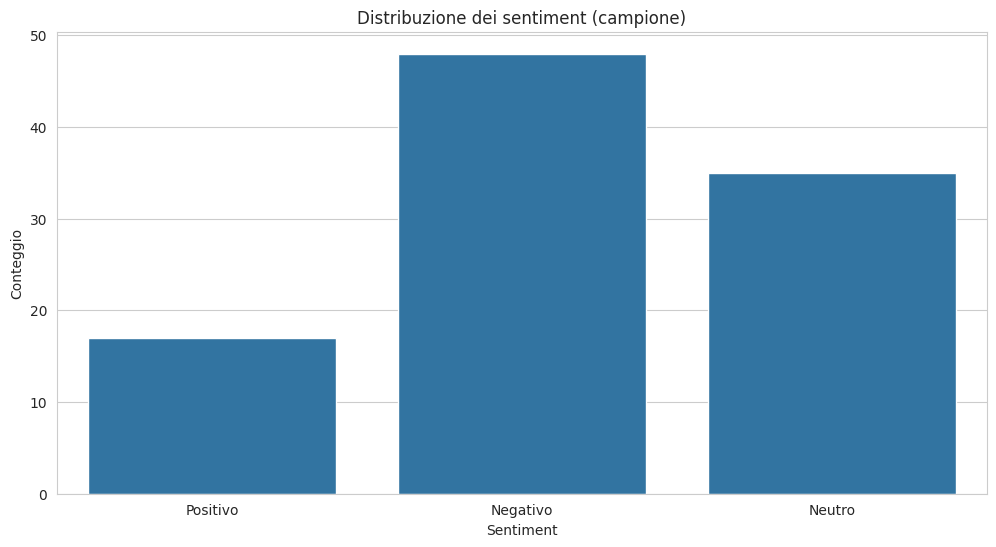

Confidenza media: 0.7270


In [31]:
# 5. Calcolare Metriche Aggregate

logs = logger.load_logs()
metrics = metrics_tracker.calculate_metrics(logs)
metrics_tracker.save_metrics(metrics)

print("Metriche aggregate:")
print(json.dumps(metrics.to_dict(), indent=2))

# Mostra distribuzione sentiment
sns.barplot(
    x=list(metrics.sentiment_distribution.keys()),
    y=list(metrics.sentiment_distribution.values())
)
plt.title("Distribuzione dei sentiment (campione)")
plt.xlabel("Sentiment")
plt.ylabel("Conteggio")
plt.show()

print(f"Confidenza media: {metrics.average_confidence:.4f}")

In [33]:
# 6. Implementare Drift Detection

logs = logger.load_logs()
# Reload drift_detection module to pick up any local patches
import importlib
import src.drift_detection as drift_mod
importlib.reload(drift_mod)
from src.drift_detection import DriftDetector
# Recreate detector instance
drift_detector = DriftDetector(baseline_file="logs/baseline_distribution.json", metrics_dir="logs", drift_threshold=0.15)

report = drift_detector.detect_drift(logs)
# Use patched save (call on class to ensure latest code path)
drift_mod.DriftDetector.save_drift_report(drift_detector, report)

print("Drift report:")

# Safe serialization for printing
import numpy as _np
from datetime import datetime as _dt

def _to_serializable(o):
    if isinstance(o, dict):
        return {k: _to_serializable(v) for k, v in o.items()}
    if isinstance(o, list):
        return [_to_serializable(v) for v in o]
    if isinstance(o, (_np.generic,)):
        return o.item()
    if isinstance(o, _np.ndarray):
        return o.tolist()
    if isinstance(o, _dt):
        return o.isoformat()
    return o

print(json.dumps(_to_serializable(report.to_dict()), indent=2))

if report.drift_detected:
    print("⚠️ Drift rilevato — considerare il retraining")
else:
    print("No drift rilevato")

Drift report:
{
  "timestamp": "2026-02-05T11:26:26.413683",
  "drift_detected": false,
  "drift_score": 0.033333333333333326,
  "drift_threshold": 0.15,
  "baseline_distribution": {
    "Neutro": 0.47,
    "Negativo": 0.31,
    "Positivo": 0.22
  },
  "current_distribution": {
    "Positivo": 0.17,
    "Negativo": 0.48,
    "Neutro": 0.35
  },
  "average_confidence_change": 0.014025240838527742,
  "recommendations": []
}
No drift rilevato


In [34]:
# 7. Implementare Trigger Retraining

logs = logger.load_logs()
trigger = retraining_manager.evaluate_retraining_need(logs)
# Ensure we use the patched save method by reloading the module and calling the class method
import importlib
import src.retraining as retraining_mod
importlib.reload(retraining_mod)
retraining_mod.RetrainingManager.save_trigger(retraining_manager, trigger)

print("Retraining trigger:")

# Serialize safely for printing
import numpy as _np
from datetime import datetime as _dt

def _to_serializable(o):
    if isinstance(o, dict):
        return {k: _to_serializable(v) for k, v in o.items()}
    if isinstance(o, list):
        return [_to_serializable(v) for v in o]
    if isinstance(o, (_np.generic,)):
        return o.item()
    if isinstance(o, _np.ndarray):
        return o.tolist()
    if isinstance(o, _dt):
        return o.isoformat()
    return o

print(json.dumps(_to_serializable(trigger.to_dict()), indent=2))

if trigger.triggered:
    print("✅ Trigger per retraining attivato: ", trigger.recommended_action)
else:
    print("Nessun retraining necessario al momento")

Retraining trigger:
{
  "timestamp": "2026-02-05T11:26:31.177365",
  "triggered": false,
  "reason": "Nessuna necessit\u00e0 di retraining",
  "confidence_threshold_met": false,
  "drift_threshold_met": false,
  "min_samples_met": true,
  "recommended_action": "\u23f3 CONTINUE MONITORING"
}
Nessun retraining necessario al momento


EVALUATION
Accuracy: 0.6950
F1 (weighted): 0.6955
Precision (weighted): 0.6970
Recall (weighted): 0.6950


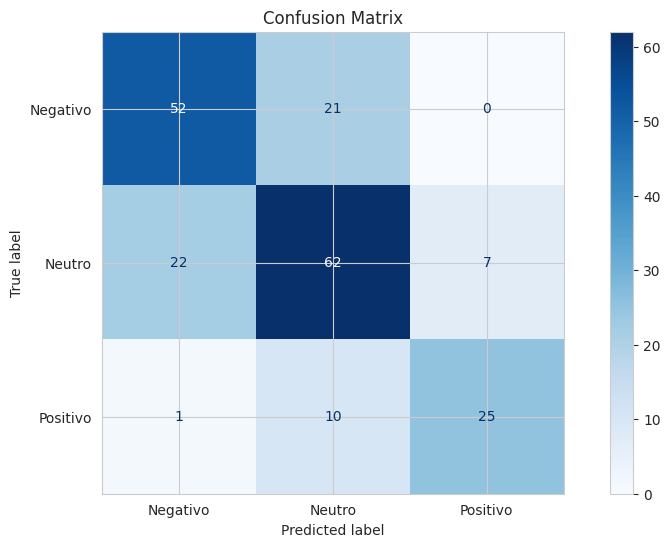

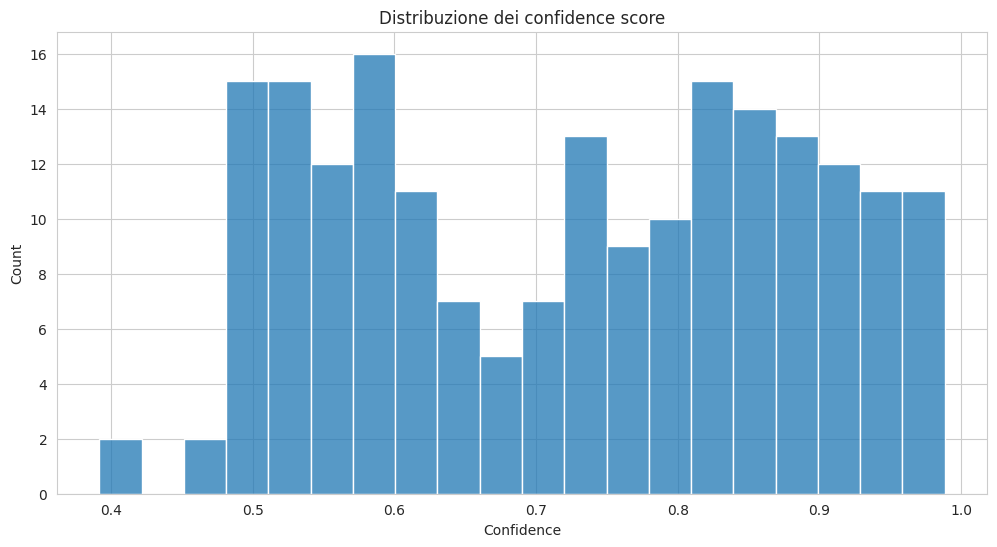

In [35]:
# 8. Valutare Modello su Test Set

from sklearn.metrics import ConfusionMatrixDisplay

# Usa un campione del test set per la valutazione
sample_size = min(200, len(dataset['test']))
indices = np.random.choice(len(dataset['test']), sample_size, replace=False)

preds = []
trues = []
confs = []

for i in indices:
    sample = dataset['test'][int(i)]
    text = sample['text']
    true_label = label_mapping[sample['label']]
    res = analyze_sentiment(text)
    pred_label = max(res, key=res.get)
    conf = res[pred_label]

    preds.append(pred_label)
    trues.append(true_label)
    confs.append(conf)

# Mappa a valori numerici
label_to_idx = {v: k for k, v in label_mapping.items()}

y_true = [label_to_idx[t] for t in trues]
y_pred = [label_to_idx[p] for p in preds]

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)

print("EVALUATION")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 (weighted): {f1:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.values()))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Distribuzione confidenza
sns.histplot(confs, bins=20)
plt.title('Distribuzione dei confidence score')
plt.xlabel('Confidence')
plt.show()

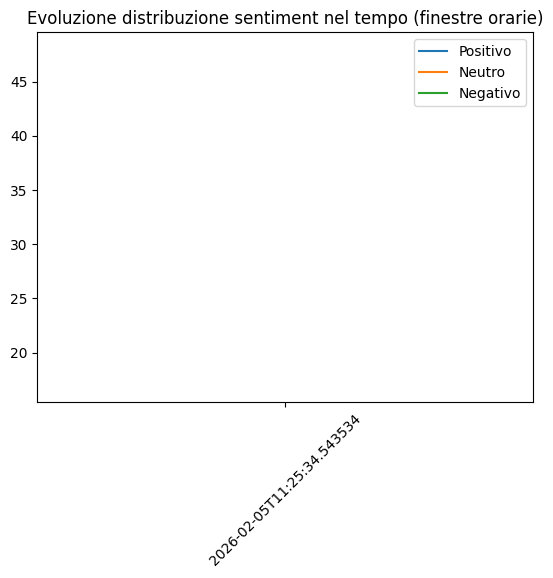

In [4]:
# 9. Visualizzare Distribuzioni Sentiment nel tempo

# Calcola metriche su finestre orarie
# Se il notebook è eseguito parzialmente, assicuriamoci che i componenti esistano
# Assicura import locali per plotting se la cella è eseguita da sola
import matplotlib.pyplot as plt
import seaborn as sns
try:
    metrics_over_time = metrics_tracker.get_metrics_over_time(logger.load_logs(), window_hours=1)
except NameError:
    # Crea istanze minime se mancanti (utile quando si esegue la cella isolatamente)
    from src.metrics import MetricsTracker
    from src.monitoring import PredictionLogger
    metrics_tracker = MetricsTracker(metrics_dir='logs')
    logger = PredictionLogger(log_dir='logs')
    metrics_over_time = metrics_tracker.get_metrics_over_time(logger.load_logs(), window_hours=1)

# Prepara i dati per il plotting
if metrics_over_time:
    timestamps = [t for t, m in metrics_over_time]
    positives = [m.sentiment_distribution.get('Positivo', 0) for t, m in metrics_over_time]
    neutrals = [m.sentiment_distribution.get('Neutro', 0) for t, m in metrics_over_time]
    negatives = [m.sentiment_distribution.get('Negativo', 0) for t, m in metrics_over_time]

    plt.plot(timestamps, positives, label='Positivo')
    plt.plot(timestamps, neutrals, label='Neutro')
    plt.plot(timestamps, negatives, label='Negativo')
    plt.xticks(rotation=45)
    plt.legend()
    plt.title('Evoluzione distribuzione sentiment nel tempo (finestre orarie)')
    plt.show()
else:
    print('Non ci sono abbastanza dati per mostrare metriche nel tempo')


In [5]:
# 10. Test unitari della funzione principale (esempi)
# Esegue un set di test rapidi per verificare logger, metrics, drift e retraining

from src.monitoring import PredictionLogger
from src.metrics import MetricsTracker
from src.drift_detection import DriftDetector
from src.retraining import RetrainingManager
from datetime import datetime

# Test 1: Logging corretto
pl = PredictionLogger(log_dir='logs')
pl.clear_logs()
res = {'Positivo': 0.9, 'Neutro': 0.09, 'Negativo': 0.01}
entry = pl.log_prediction('Test logging', res)
assert pl.get_logs_count() >= 1
print('Test 1 passed: logging corretto')

# Test 2: Metrics aggregation
mt = MetricsTracker(metrics_dir='logs')
logs = pl.load_logs()
metrics = mt.calculate_metrics(logs)
assert metrics.total_predictions >= 1
print('Test 2 passed: metrics aggregation')

# Test 3: Drift detection con distribuzioni artificiali
from src.monitoring import PredictionLog
fake_logs = [
    PredictionLog(timestamp=datetime.now().isoformat(), text='t1', sentiment='Positivo', confidence=0.9, scores={'Positivo':0.9,'Neutro':0.08,'Negativo':0.02})
    for _ in range(60)
]

det = DriftDetector(baseline_file='logs/baseline_test.json', metrics_dir='logs', drift_threshold=0.1)
det.set_baseline(fake_logs[:30])
report = det.detect_drift(fake_logs[30:])
print('Test 3 passed: drift detection eseguito', report.drift_detected)

# Test 4: Retraining trigger
rm = RetrainingManager(min_samples_for_retraining=10, confidence_threshold=0.95, drift_detector=det, metrics_dir='logs')
trigger = rm.evaluate_retraining_need(fake_logs)
print('Test 4 passed: retraining evaluated', trigger.triggered)

print('✅ Tutti i test rapidi sono stati eseguiti')

Test 1 passed: logging corretto
Test 2 passed: metrics aggregation
Test 3 passed: drift detection eseguito False
Test 4 passed: retraining evaluated True
✅ Tutti i test rapidi sono stati eseguiti
